# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

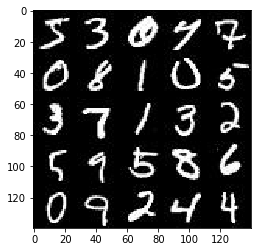

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

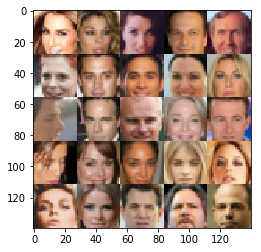

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/thiagoricieri/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, 
                                (None, image_width, image_height, image_channels), 
                                name='input_real')
    
    z_data = tf.placeholder(tf.float32, 
                             (None, z_dim), 
                             name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, 
                                   None, 
                                   name='learning_rate')
    
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/Users/thiagoricieri/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/Users/thiagoricieri/anaconda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/Users/thiagoricieri/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/Users/thiagoricieri/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/Users/thiagoricieri/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/Users/thiagoricieri/anaconda

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def leaky_relu(x, alpha=0.05, name='leaky_relu'): 
    return tf.maximum(x, alpha * x, name=name)

def discriminator(images, reuse=False, alpha=0.2, stddev=0.02, rate=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        layer_1 = tf.layers.conv2d(images, 
                                   32, 5, 2, 
                                   padding='same', 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_1 = leaky_relu(layer_1)
        layer_1 = tf.layers.dropout(layer_1, rate, training=True)
        
        layer_2 = tf.layers.conv2d(layer_1, 
                                   64, 5, 2, 
                                   padding='same', 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = leaky_relu(layer_2)
        layer_2 = tf.layers.dropout(layer_2, rate, training=True)
        
        layer_3 = tf.layers.conv2d(layer_2, 
                                   128, 5, 2, 
                                   padding='same',  
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)        
        layer_3 = leaky_relu(layer_3)
        layer_3 = tf.layers.dropout(layer_3, rate, training=True)
        
        layer_4 = tf.layers.conv2d(layer_3, 
                                   256, 5, 2, 
                                   padding='same', 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = leaky_relu(layer_4)
        layer_4 = tf.layers.dropout(layer_4, rate, training=True)
        
        flattened = tf.reshape(layer_4, (-1, 2 * 2 * 256))
        logits = tf.layers.dense(flattened, 1, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, stddev=0.02, rate=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = leaky_relu(layer_1)
        layer_1 = tf.layers.dropout(layer_1, rate, training=True)
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 
                                             128, 4, 1, 
                                             padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = leaky_relu(layer_2)
        layer_2 = tf.layers.dropout(layer_2, rate, training=True)
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 
                                             64, 5, 2, 
                                             padding='same', 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = leaky_relu(layer_3)
        layer_3 = tf.layers.dropout(layer_3, rate, training=True)
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 
                                             32, 5, 2, 
                                             padding='same', 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = leaky_relu(layer_4)
        layer_4 = tf.layers.dropout(layer_4, rate, training=True)
        
        logits = tf.layers.conv2d_transpose(layer_4, 
                                            out_channel_dim, 
                                            3, 1, 
                                            padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_real,
            labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake,
            labels=tf.zeros_like(dis_logits_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake,
            labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.4829
Epoch 1/2... Discriminator Loss: 1.6245... Generator Loss: 0.3556
Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 2.3323
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 1.0086
Epoch 1/2... Discriminator Loss: 1.1874... Generator Loss: 3.5253
Epoch 1/2... Discriminator Loss: 0.4229... Generator Loss: 3.2470
Epoch 1/2... Discriminator Loss: 2.5330... Generator Loss: 0.1518
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 2.5144
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.6377
Epoch 1/2... Discriminator Loss: 0.9585... Generator Loss: 1.4356


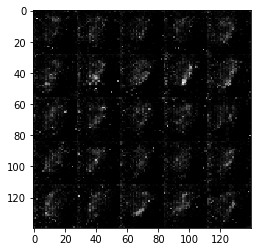

Epoch 1/2... Discriminator Loss: 0.8525... Generator Loss: 1.8693
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.0963
Epoch 1/2... Discriminator Loss: 1.7483... Generator Loss: 3.4749
Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 1.5109
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.3603
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 1.6736... Generator Loss: 3.3449
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.1429
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 0.9092


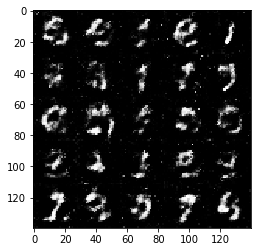

Epoch 1/2... Discriminator Loss: 1.1121... Generator Loss: 2.4458
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 1.7366
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.3140
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 0.7659... Generator Loss: 1.5721
Epoch 1/2... Discriminator Loss: 0.8861... Generator Loss: 1.2884
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.0870
Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 0.4896
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 1.6406


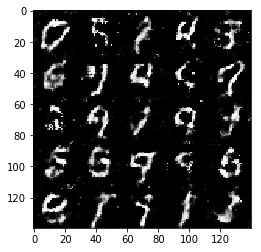

Epoch 1/2... Discriminator Loss: 0.8300... Generator Loss: 1.4108
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 0.8260... Generator Loss: 1.2571
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.2580
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 0.8184
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 1.3860
Epoch 1/2... Discriminator Loss: 1.8908... Generator Loss: 0.2396
Epoch 1/2... Discriminator Loss: 0.6224... Generator Loss: 1.7868
Epoch 1/2... Discriminator Loss: 1.1732... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.7184


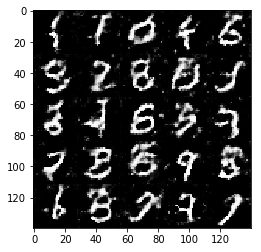

Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.0209
Epoch 1/2... Discriminator Loss: 0.7156... Generator Loss: 1.4303
Epoch 1/2... Discriminator Loss: 0.7350... Generator Loss: 2.1216
Epoch 1/2... Discriminator Loss: 0.8918... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 1.8961
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 2.1207
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 0.7099... Generator Loss: 1.9488
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 2.2022
Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 1.5183


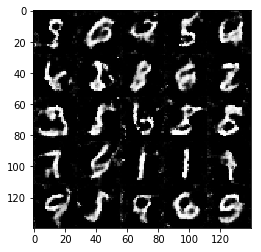

Epoch 1/2... Discriminator Loss: 0.7075... Generator Loss: 1.7914
Epoch 1/2... Discriminator Loss: 0.8016... Generator Loss: 1.3617
Epoch 1/2... Discriminator Loss: 0.8534... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 0.7435... Generator Loss: 1.6936
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 1.4866
Epoch 1/2... Discriminator Loss: 1.0031... Generator Loss: 1.2000
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.2748
Epoch 1/2... Discriminator Loss: 1.0353... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.8113
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 1.6769


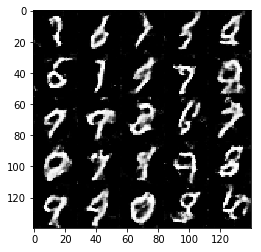

Epoch 1/2... Discriminator Loss: 0.6724... Generator Loss: 1.5910
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 2.4758
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 1.0632
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.1738
Epoch 1/2... Discriminator Loss: 1.0834... Generator Loss: 1.0699
Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.9652
Epoch 1/2... Discriminator Loss: 0.5967... Generator Loss: 1.4759
Epoch 1/2... Discriminator Loss: 1.8856... Generator Loss: 0.3565
Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 0.6847... Generator Loss: 1.7402


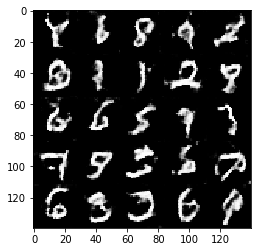

Epoch 1/2... Discriminator Loss: 0.9469... Generator Loss: 1.1769
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 3.1101
Epoch 1/2... Discriminator Loss: 0.5413... Generator Loss: 1.8620
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.7285
Epoch 1/2... Discriminator Loss: 0.5285... Generator Loss: 2.8359
Epoch 1/2... Discriminator Loss: 0.5249... Generator Loss: 2.0445
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.5570
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 1.5247
Epoch 1/2... Discriminator Loss: 0.5387... Generator Loss: 2.1090


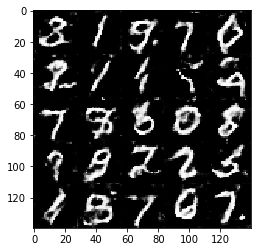

Epoch 1/2... Discriminator Loss: 0.5475... Generator Loss: 2.3411
Epoch 1/2... Discriminator Loss: 0.4949... Generator Loss: 2.8413
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 4.9221
Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 2.1472
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 4.4481
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.4447
Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 1.0576
Epoch 1/2... Discriminator Loss: 0.5371... Generator Loss: 2.0034
Epoch 1/2... Discriminator Loss: 0.5471... Generator Loss: 1.9248
Epoch 1/2... Discriminator Loss: 0.5183... Generator Loss: 2.4053


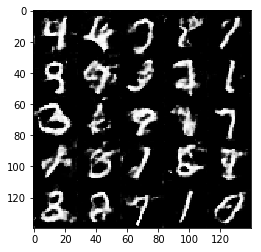

Epoch 1/2... Discriminator Loss: 0.6256... Generator Loss: 2.7271
Epoch 1/2... Discriminator Loss: 0.7018... Generator Loss: 1.0665
Epoch 1/2... Discriminator Loss: 0.6978... Generator Loss: 2.2147
Epoch 2/2... Discriminator Loss: 0.5306... Generator Loss: 1.3658
Epoch 2/2... Discriminator Loss: 0.5690... Generator Loss: 2.3554
Epoch 2/2... Discriminator Loss: 0.7882... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 3.8882
Epoch 2/2... Discriminator Loss: 0.6611... Generator Loss: 3.1147
Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 1.5252
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.9085


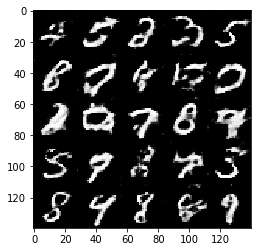

Epoch 2/2... Discriminator Loss: 0.4917... Generator Loss: 2.8474
Epoch 2/2... Discriminator Loss: 0.5869... Generator Loss: 3.4278
Epoch 2/2... Discriminator Loss: 0.6051... Generator Loss: 2.7986
Epoch 2/2... Discriminator Loss: 0.9361... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 0.6784... Generator Loss: 1.6194
Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 1.1511
Epoch 2/2... Discriminator Loss: 0.5885... Generator Loss: 2.6543
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 4.5835
Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 3.2360


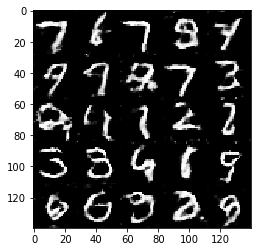

Epoch 2/2... Discriminator Loss: 0.4868... Generator Loss: 2.6602
Epoch 2/2... Discriminator Loss: 0.4029... Generator Loss: 3.7757
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.9696
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 2.1224
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 3.3167
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 3.7153
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 2.3752
Epoch 2/2... Discriminator Loss: 0.5236... Generator Loss: 1.6165
Epoch 2/2... Discriminator Loss: 0.5373... Generator Loss: 2.2990
Epoch 2/2... Discriminator Loss: 0.4708... Generator Loss: 2.7616


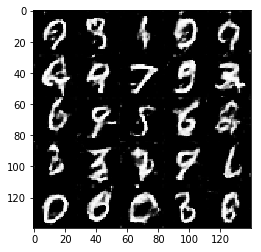

Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 4.0177
Epoch 2/2... Discriminator Loss: 0.5935... Generator Loss: 3.6098
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.6497
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 0.6694... Generator Loss: 2.6001
Epoch 2/2... Discriminator Loss: 0.4392... Generator Loss: 2.4989
Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 2.0603
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 1.6622
Epoch 2/2... Discriminator Loss: 0.5594... Generator Loss: 2.5109
Epoch 2/2... Discriminator Loss: 0.5091... Generator Loss: 4.1405


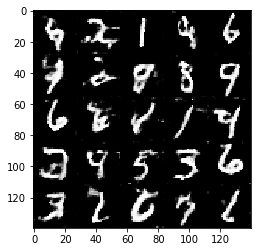

Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 2.4693
Epoch 2/2... Discriminator Loss: 1.4881... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 3.1618
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 3.3721
Epoch 2/2... Discriminator Loss: 0.6982... Generator Loss: 1.4235
Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 2.2854
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 2.1864
Epoch 2/2... Discriminator Loss: 0.5937... Generator Loss: 4.3032
Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 4.4938
Epoch 2/2... Discriminator Loss: 0.5515... Generator Loss: 1.2265


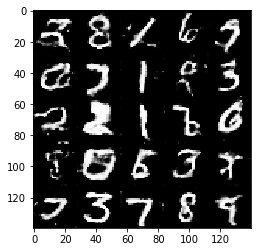

Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 2.1559
Epoch 2/2... Discriminator Loss: 0.5996... Generator Loss: 3.6892
Epoch 2/2... Discriminator Loss: 2.6300... Generator Loss: 6.2448
Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 3.0668
Epoch 2/2... Discriminator Loss: 0.5244... Generator Loss: 2.9143
Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 2.1288
Epoch 2/2... Discriminator Loss: 0.5459... Generator Loss: 2.9713
Epoch 2/2... Discriminator Loss: 0.4869... Generator Loss: 3.3877
Epoch 2/2... Discriminator Loss: 0.5014... Generator Loss: 2.5780
Epoch 2/2... Discriminator Loss: 0.4134... Generator Loss: 3.8270


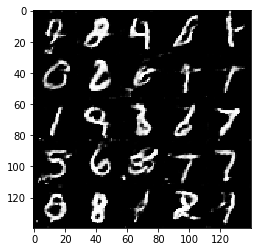

Epoch 2/2... Discriminator Loss: 0.6286... Generator Loss: 2.3197
Epoch 2/2... Discriminator Loss: 0.5361... Generator Loss: 1.4262
Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 2.4092
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 6.9777
Epoch 2/2... Discriminator Loss: 0.4275... Generator Loss: 2.6413
Epoch 2/2... Discriminator Loss: 0.5009... Generator Loss: 4.0495
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 1.7920
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 3.1288
Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 0.8389
Epoch 2/2... Discriminator Loss: 0.4557... Generator Loss: 2.3449


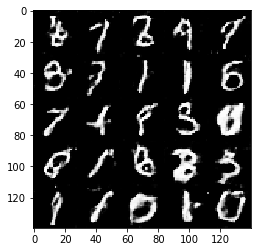

Epoch 2/2... Discriminator Loss: 1.5232... Generator Loss: 5.9525
Epoch 2/2... Discriminator Loss: 0.4675... Generator Loss: 2.2508
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 5.6038
Epoch 2/2... Discriminator Loss: 1.0869... Generator Loss: 1.4211
Epoch 2/2... Discriminator Loss: 0.4684... Generator Loss: 3.0095
Epoch 2/2... Discriminator Loss: 0.4540... Generator Loss: 2.2407
Epoch 2/2... Discriminator Loss: 0.5118... Generator Loss: 2.7021
Epoch 2/2... Discriminator Loss: 0.5012... Generator Loss: 2.5842
Epoch 2/2... Discriminator Loss: 0.5636... Generator Loss: 2.1507
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.7488


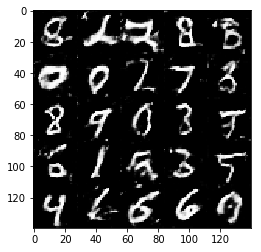

Epoch 2/2... Discriminator Loss: 0.4501... Generator Loss: 2.4372
Epoch 2/2... Discriminator Loss: 1.2754... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 1.7407
Epoch 2/2... Discriminator Loss: 0.5209... Generator Loss: 2.3028
Epoch 2/2... Discriminator Loss: 0.5261... Generator Loss: 3.0279
Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 2.8125
Epoch 2/2... Discriminator Loss: 0.4838... Generator Loss: 3.0398
Epoch 2/2... Discriminator Loss: 0.4008... Generator Loss: 4.1330
Epoch 2/2... Discriminator Loss: 0.3997... Generator Loss: 4.6242
Epoch 2/2... Discriminator Loss: 0.7818... Generator Loss: 1.3332


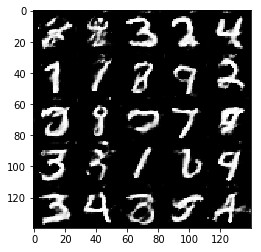

Epoch 2/2... Discriminator Loss: 0.5547... Generator Loss: 1.9882
Epoch 2/2... Discriminator Loss: 0.5687... Generator Loss: 3.5518
Epoch 2/2... Discriminator Loss: 0.6994... Generator Loss: 3.5287
Epoch 2/2... Discriminator Loss: 0.5574... Generator Loss: 1.4558
Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 2.7169
Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 2.3450
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 2.8661


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.